In [4]:
# imports
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.container import BarContainer

In [5]:
# -----------------------
# Lane order + colors
# -----------------------
lane_order = ["IGVFDS9332KWPJ", "IGVFDS8721BKRO", "IGVFDS9613DDRB", "IGVFDS6244NAXC"]
lane_colors = {
    "IGVFDS6244NAXC": "#1f77b4",
    "IGVFDS8721BKRO": "#ff7f0e",
    "IGVFDS9332KWPJ": "#2ca02c",
    "IGVFDS9613DDRB": "#d62728",
}

/tmp/ipykernel_3308105/244387048.py:92: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  sns.barplot(
/tmp/ipykernel_3308105/244387048.py:92: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  sns.barplot(
/tmp/ipykernel_3308105/244387048.py:92: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  sns.barplot(
/tmp/ipykernel_3308105/244387048.py:92: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  sns.barplot(
/tmp/ipykernel_3308105/244387048.py:92: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4

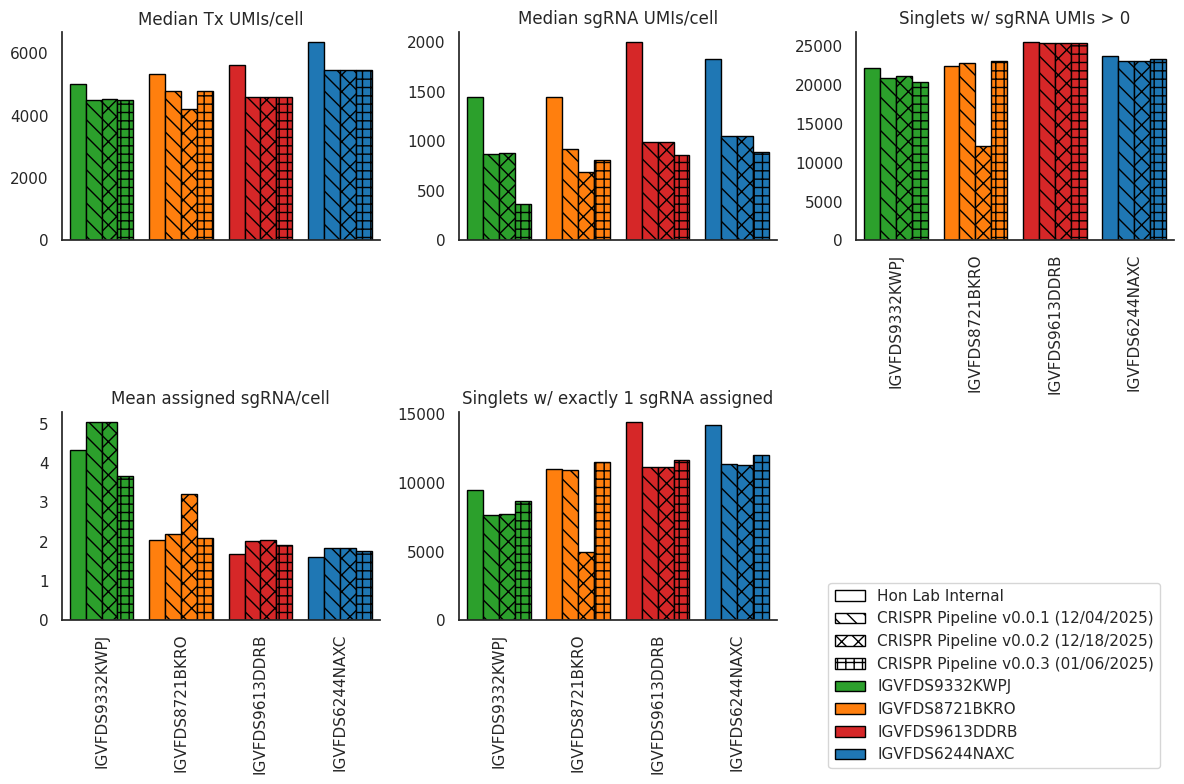

In [6]:
# -----------------------
# Read the new-format TSV
# -----------------------
path_tsv = "/cellar/users/aklie/data/datasets/tf_perturb_seq/scratch/2026_01_05/Hon_comparison.tsv"
wide = pd.read_csv(path_tsv, sep="\t")

# normalize column names (optional but helps avoid typos)
wide = wide.rename(columns={
    "Lane": "lane",
    "Pipeline": "pipeline",
    "Median Tx UMIs/cell": "median_txn_umi_per_cell",
    "Median sgRNA UMIs/cell": "median_sgrna_umi_per_cell",
    "Singlets w/ sgRNA UMIs > 0": "gt0_sgrna",
    "Mean assigned sgRNA/cell": "mean_sgrna_per_cell",
    "Singlets w/ exactly 1 sgRNA assigned": "exactly1_sgrna",
})

# ensure expected columns exist
required = ["lane", "pipeline", "median_txn_umi_per_cell", "median_sgrna_umi_per_cell",
            "gt0_sgrna", "mean_sgrna_per_cell", "exactly1_sgrna"]
missing = [c for c in required if c not in wide.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# ensure numeric cols are numeric (NA -> NaN)
numeric_cols = [c for c in wide.columns if c not in ["lane", "pipeline"]]
for c in numeric_cols:
    wide[c] = pd.to_numeric(wide[c], errors="coerce")

# -----------------------
# Metrics to facet
# -----------------------
metrics_to_plot = [
    "median_txn_umi_per_cell",
    "median_sgrna_umi_per_cell",
    "gt0_sgrna",
    "mean_sgrna_per_cell",
    "exactly1_sgrna",
]

metric_labels = {
    "median_txn_umi_per_cell": "Median Tx UMIs/cell",
    "median_sgrna_umi_per_cell": "Median sgRNA UMIs/cell",
    "gt0_sgrna": "Singlets w/ sgRNA UMIs > 0",
    "mean_sgrna_per_cell": "Mean assigned sgRNA/cell",
    "exactly1_sgrna": "Singlets w/ exactly 1 sgRNA assigned",
}

df = wide.melt(
    id_vars=["lane", "pipeline"],
    value_vars=metrics_to_plot,
    var_name="metric",
    value_name="value",
)
df["metric"] = df["metric"].map(metric_labels)

# -----------------------
# Pipeline order + hatches (edit names here if you tweak labels)
# -----------------------
pipeline_order = [
    "Hon Lab Internal",
    "CRISPR Pipeline v0.0.1 (12/04/2025)",
    "CRISPR Pipeline v0.0.2 (12/18/2025)",
    "CRISPR Pipeline v0.0.3 (01/06/2025)"
]
pipeline_hatches = {
    "Hon Lab Internal": "",
    "CRISPR Pipeline v0.0.1 (12/04/2025)": "\\\\",
    "CRISPR Pipeline v0.0.2 (12/18/2025)": "xx",
    "CRISPR Pipeline v0.0.3 (01/06/2025)": "++",
}

# -----------------------
# Presentation-ish params
# -----------------------
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 24,
    "axes.labelsize": 24,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
})
sns.set(style="white")

# -----------------------
# Custom barplot: lane colors + pipeline hatches
# -----------------------
def barplot_with_lane_color_and_pipeline_hatch(data, x, y, hue, **kwargs):
    ax = plt.gca()

    sns.barplot(
        data=data,
        x=x,
        y=y,
        hue=hue,
        order=lane_order,
        hue_order=pipeline_order,
        dodge=True,
        edgecolor="black",
        **kwargs
    )

    # only bar containers (ignore errorbar containers)
    bar_containers = [c for c in ax.containers if isinstance(c, BarContainer)]

    # each container corresponds to one hue (pipeline), in hue_order
    for p_idx, container in enumerate(bar_containers):
        if p_idx >= len(pipeline_order):
            continue
        pipeline = pipeline_order[p_idx]

        for i, patch in enumerate(container.patches):
            if i >= len(lane_order):
                continue
            lane = lane_order[i]
            patch.set_facecolor(lane_colors[lane])
            patch.set_hatch(pipeline_hatches[pipeline])

# -----------------------
# FacetGrid
# -----------------------
g = sns.FacetGrid(
    df,
    col="metric",
    col_wrap=3,
    sharey=False,
    height=4
)

g.map_dataframe(
    barplot_with_lane_color_and_pipeline_hatch,
    x="lane",
    y="value",
    hue="pipeline"
)

# axis cleanup
for ax in g.axes.flatten():
    ax.set_xlabel("")
    ax.set_ylabel("")  # cleaner; metric label already in title
    ax.tick_params(axis="x", rotation=90)

# remove per-axis legends
for ax in g.axes.flatten():
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

# -----------------------
# Legends: pipelines (hatch) + lanes (color)
# -----------------------
pipeline_handles = [
    Patch(facecolor="white", edgecolor="black", hatch=pipeline_hatches[p], label=p)
    for p in pipeline_order
]
lane_handles = [
    Patch(facecolor=lane_colors[l], edgecolor="black", label=l)
    for l in lane_order
]
all_handles = pipeline_handles + lane_handles

g.fig.legend(
    handles=all_handles,
    loc="lower right",
    bbox_to_anchor=(0.98, 0.02),
    borderaxespad=0.5
)

g.set_titles("{col_name}")
plt.tight_layout()
plt.show()


# DONE!

---